# ECG Asystole Detection — Full Notebook (Self‑Contained)

This notebook contains a complete, self‑contained pipeline to:

1) Load a 1D ECG signal from CSV (first column)
2) Fast Fourier Transform (FFT)
3) Band‑pass filter (5–50 Hz)
4) Robust R‑peak detection (MAD‑adaptive + width + slope)
5) Sliding‑window asystole detection (4 s window, 1 s hop, **≥3 s without R**)
6) Plot overview (raw + alarm) and a spectrogram (0–60 Hz)
7) Export JSON summary and an optional HTML report
8) (Optional) Batch process a folder of CSVs

> Tip: Put your file path into `ecg_csv_path` below. Sampling rate defaults to 250 Hz.

References:

Pan, J., & Tompkins, W. J. (1985). A real-time QRS detection algorithm. IEEE transactions on bio-medical engineering, 32(3), 230–236. https://doi.org/10.1109/TBME.1985.325532

Sörnmo, L., & Laguna, P. (2005). Bioelectrical signal processing in cardiac and neurological applications. San Diego, CA: Elsevier Academic Press.

Clifford, G. D., Azuaje, F., & McSharry, P. E. (Eds.). (2006). Advanced methods and tools for ECG data analysis. Boston, MA: Artech House.

Kligfield, P., Gettes, L. S., Bailey, J. J., Childers, R., Deal, B. J., Hancock, E. W., van Herpen, G., Kors, J. A., Macfarlane, P., Mirvis, D. M., Pahlm, O., Rautaharju, P., Wagner, G. S., American Heart Association Electrocardiography and Arrhythmias Committee, Council on Clinical Cardiology, American College of Cardiology Foundation, Heart Rhythm Society, Josephson, M., Mason, J. W., Okin, P., Surawicz, B., … Wellens, H. (2007). Recommendations for the standardization and interpretation of the electrocardiogram: part I: The electrocardiogram and its technology: a scientific statement from the American Heart Association Electrocardiography and Arrhythmias Committee, Council on Clinical Cardiology; the American College of Cardiology Foundation; and the Heart Rhythm Society: endorsed by the International Society for Computerized Electrocardiology. Circulation, 115(10), 1306–1324. https://doi.org/10.1161/CIRCULATIONAHA.106.180200

In [85]:
# ---- User config ----
Fs = 250.0      # Sampling rate (Hz)
pause_thr_sec = 3.0      # Asystole threshold (s): ≥3.0 s without R-peak
out_plot = "overview.png"      # Where to save the overview plot
out_tfr  = "spectrogram.png"      # Where to save the spectrogram
out_json = "summary.json"      # Where to save a JSON summary
out_html = "report.html"      # Where to save an HTML report (set to None to skip)


In [86]:
# ---- Imports ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, sosfiltfilt, find_peaks, peak_widths, spectrogram
from tkinter import Tk, filedialog

print("Libraries imported.")

Tk().withdraw()
file_path = filedialog.askopenfilename(
    title="Select ECG CSV",
    filetypes=[("CSV files", "*.csv"), ("All files", "*.*")])
ecg_csv_path = Path(file_path) # Path to your ECG CSV (first column used)

Libraries imported.


In [87]:
# ---- I/O ----
def read_csv_first_col(path):
    """Read a CSV and return the first column as float 1D array."""
    df = pd.read_csv(path, header=None)
    x = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy(dtype=float).ravel()
    return x
    
def ensure_exists(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p.resolve()}")
    return p




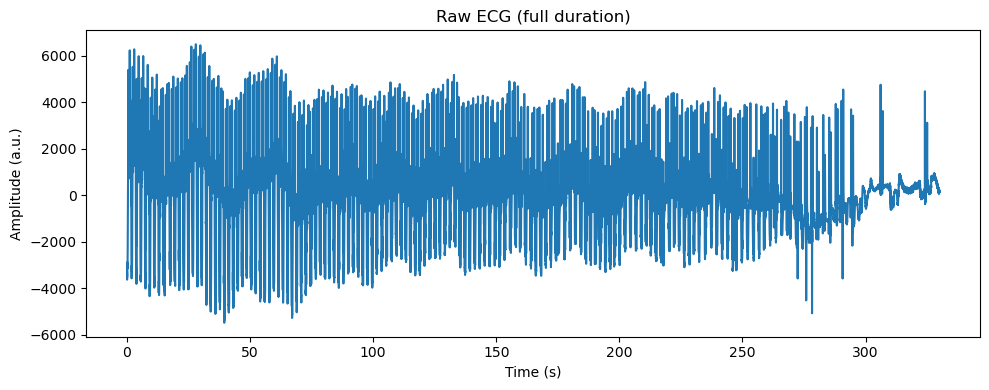

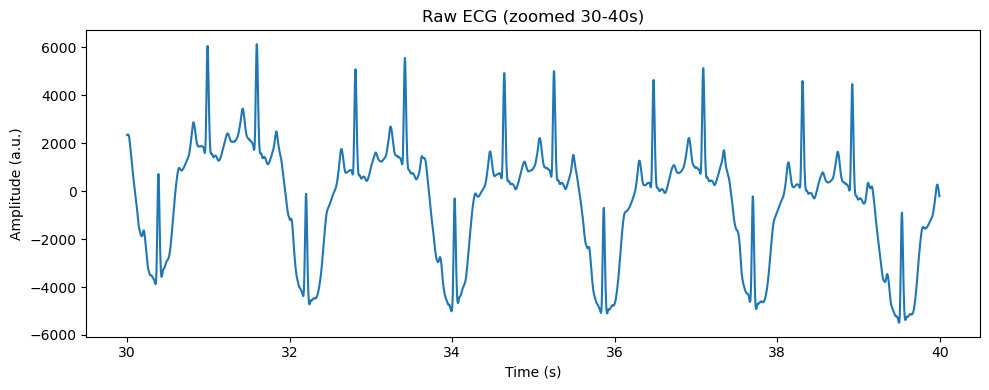

In [88]:
# ----Plot the raw ECG signal ----
fs = 250  # Hz
df = pd.read_csv(ecg_csv_path, header=None)
ecg = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy()
t = np.arange(ecg.size) / fs

plt.figure(figsize=(10, 4))
plt.plot(t, ecg)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")
plt.title("Raw ECG (full duration)")
plt.tight_layout()
plt.show()

start_sec = 30
window_sec = 10
i0 = int(start_sec * fs)
i1 = int((start_sec + window_sec) * fs)

plt.figure(figsize=(10, 4))
plt.plot(t[i0:i1], ecg[i0:i1])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (a.u.)")
plt.title(f"Raw ECG (zoomed {start_sec}-{start_sec + window_sec}s)")
plt.tight_layout()
plt.show()

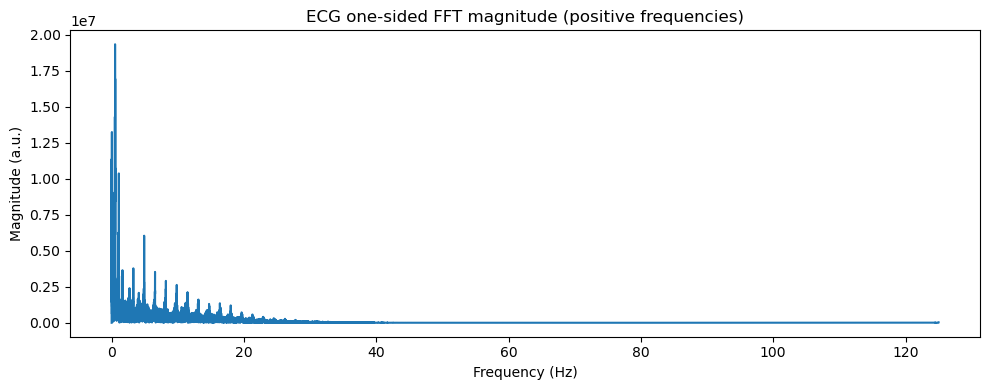

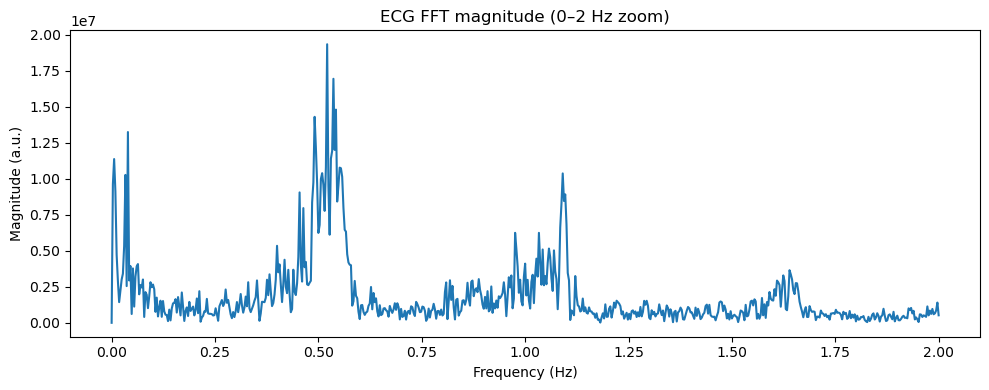

In [89]:
# ---- FFT ----
# Note: Before performing the transform, make sure the signal is stored as a 1D NumPy array
fs = 250  # Hz
ecg = pd.read_csv(ecg_csv_path, header=None).iloc[:, 0].to_numpy().ravel()
N = ecg.size

ecg_detrended = ecg - np.mean(ecg)
X = np.fft.rfft(ecg_detrended)                # complex spectrum, positive freqs only
f = np.fft.rfftfreq(N, d=1/fs)                # matching positive frequencies (Hz)
mag = np.abs(X)                               # magnitude spectrum

plt.figure(figsize=(10,4))
plt.plot(f, mag)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (a.u.)")
plt.title("ECG one-sided FFT magnitude (positive frequencies)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
mask = (f >= 0) & (f <= 2)
plt.plot(f[mask], mag[mask])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (a.u.)")
plt.title("ECG FFT magnitude (0–2 Hz zoom)")
plt.tight_layout()
plt.show()

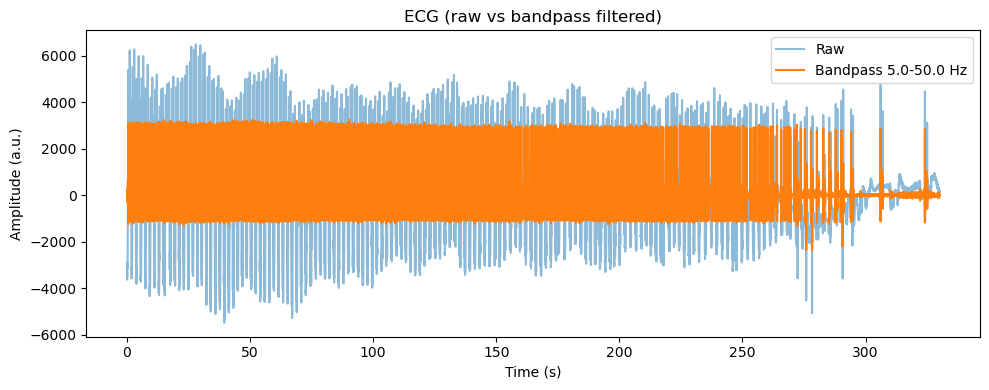

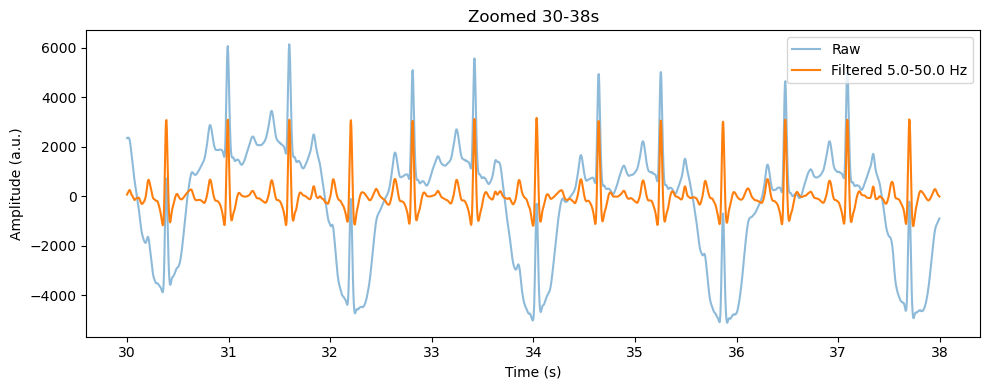

In [90]:
# ---- Filtering ----
# Bandpass Filtering to Remove Noise
def bandpass(x, fs, low=5.0, high=50.0, order=4):
    ny = fs / 2.0
    sos = butter(order, [low/ny, high/ny], btype="bandpass", output="sos")
    return sosfiltfilt(sos, x)
    
lowcut, highcut = 5.0, 50.0
nyq = fs / 2.0
sos = butter(N=4, Wn=[lowcut/nyq, highcut/nyq], btype="bandpass", output="sos")
ecg_filt = sosfiltfilt(sos, ecg.astype(float))

plt.figure(figsize=(10, 4))
plt.plot(t, ecg, alpha=0.5, label="Raw")
plt.plot(t, ecg_filt, label=f"Bandpass {lowcut}-{highcut} Hz")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (a.u.)"); plt.title("ECG (raw vs bandpass filtered)")
plt.legend()
plt.tight_layout()
plt.show()

start_sec, window_sec = 30, 8
i0, i1 = int(start_sec*fs), int((start_sec+window_sec)*fs)
plt.figure(figsize=(10, 4))
plt.plot(t[i0:i1], ecg[i0:i1], alpha=0.5, label="Raw")
plt.plot(t[i0:i1], ecg_filt[i0:i1], label=f"Filtered {lowcut}-{highcut} Hz")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude (a.u.)"); plt.title(f"Zoomed {start_sec}-{start_sec+window_sec}s")
plt.legend()
plt.tight_layout()
plt.show()

# Removes low-frequency drift (baseline wander/DC, <≈ 0.5 Hz) and high-frequency noise (EMG, instrumentation) 
# Preserving the QRS-dominated band that carries most diagnostic energy for beat detection (roughly a few to ~15 Hz)
# A low-pass only would keep the DC/baseline wander, smearing ST-segment and amplitude baselines. Samely, a high-pass only would remove the drift but leave high-frequency noise that corrupts R-peaks and derivatives
# Zero-phase bandpass (e.g., filtfilt) also avoids QRS timing distortion. 

Selected 5-s window: 27.42–32.42 s (max mean-square difference)


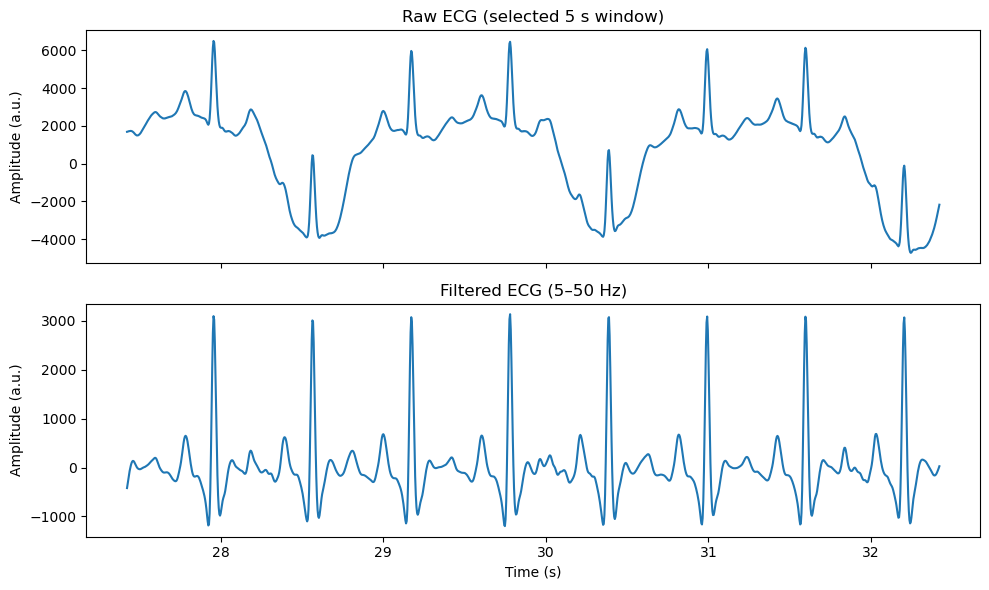

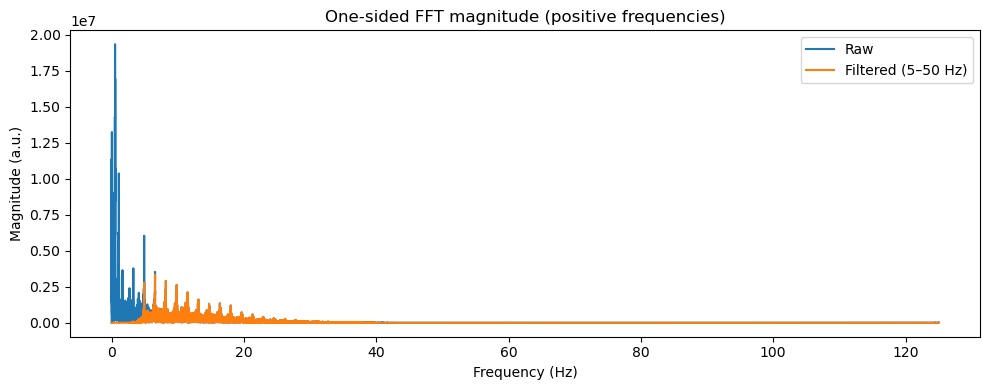

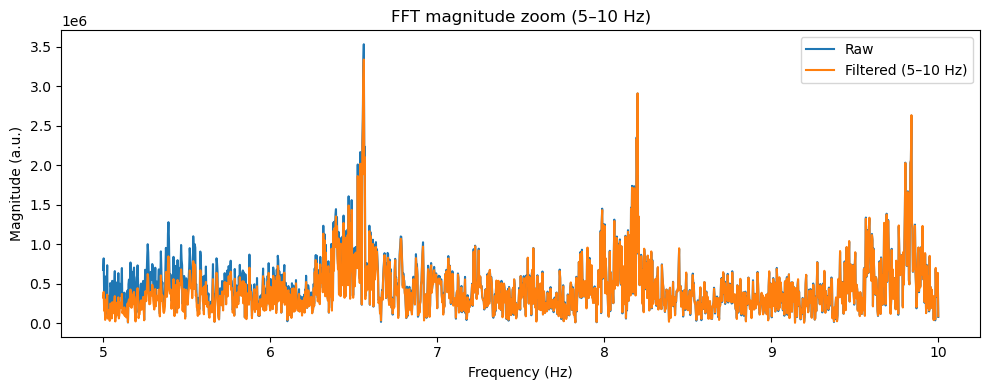

In [91]:
# ---- Comparison ----
# Comparison between Raw and Filtered Signals in the Time Domain
# Identify a 5-second window where the filtered ECG differs significantly from the raw ECG in the same interval
ecg = ecg.ravel()

nyq = fs / 2.0
sos = butter(4, [5.0/nyq, 50.0/nyq], btype="bandpass", output="sos")
ecg_filt = sosfiltfilt(sos, ecg)

win_sec = 5.0
win = int(win_sec * fs)
diff = ecg - ecg_filt
mse = np.convolve(diff**2, np.ones(win, dtype=float), mode="valid") / win

# Where the window begins
k = int(np.argmax(mse))
i0, i1 = k, k + win
t0, t1 = i0/fs, i1/fs
print(f"Selected 5-s window: {t0:.2f}–{t1:.2f} s (max mean-square difference)")

# Plot: Raw and Filtered ECG
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t[i0:i1], ecg[i0:i1])
axes[0].set_title("Raw ECG (selected 5 s window)")
axes[0].set_ylabel("Amplitude (a.u.)")

axes[1].plot(t[i0:i1], ecg_filt[i0:i1])
axes[1].set_title("Filtered ECG (5–50 Hz)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()

# Comparison between Raw and Filtered Signals in the Frequency Domain
N = ecg.size
# Remove DC before FFT
x_raw  = ecg - np.mean(ecg)
x_filt = ecg_filt - np.mean(ecg_filt)

# One-sided FFT magnitudes
Xr = np.fft.rfft(x_raw)
Xf = np.fft.rfft(x_filt)
f  = np.fft.rfftfreq(N, d=1/fs)
mag_raw  = np.abs(Xr)
mag_filt = np.abs(Xf)

# Plot: Full positive half
plt.figure(figsize=(10,4))
plt.plot(f, mag_raw,  label="Raw")
plt.plot(f, mag_filt, label="Filtered (5–50 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (a.u.)")
plt.title("One-sided FFT magnitude (positive frequencies)")
plt.legend(); plt.tight_layout(); plt.show()

# Plot: Zoom to 0–80 Hz to see ECG bands and line noise
plt.figure(figsize=(10,4))
mask = (f >= 5) & (f <= 10)
plt.plot(f[mask], mag_raw[mask],  label="Raw")
plt.plot(f[mask], mag_filt[mask], label="Filtered (5–10 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (a.u.)")
plt.title("FFT magnitude zoom (5–10 Hz)")
plt.legend(); plt.tight_layout(); plt.show()

In [92]:
# ---- R-peak detection ----
def _mad(a):
    med = np.median(a)
    return np.median(np.abs(a - med)) + 1e-12

def detect_r_peaks(
    xf, fs,
    prom_mult=6.0, height_mult=3.0,
    width_min_ms=25.0, width_max_ms=120.0,
    slope_mult=4.0, slope_win_ms=20.0,
    min_rr_sec=0.25):
    """Robust R-peak detector on a filtered ECG.

    - MAD-adaptive prominence/height thresholds

    - Half-height width constraint (~25–120 ms)

    - Local slope gate (±20 ms window)

    """
    sig = xf - np.median(xf)
    m = _mad(sig)
    peaks, _ = find_peaks(sig,
                          prominence=prom_mult * m,
                          height=height_mult * m,
                          distance=int(min_rr_sec * fs))
    if peaks.size == 0:
        return peaks

    # Width at half height
    w, _, _, _ = peak_widths(sig, peaks, rel_height=0.5)
    keep_w = (w >= (width_min_ms/1000.0)*fs) & (w <= (width_max_ms/1000.0)*fs)

    # Slope gate
    d = np.diff(sig, prepend=sig[0])
    win = int((slope_win_ms/1000.0) * fs)
    slopes = []
    for p in peaks:
        i0, i1 = max(0, p - win), min(d.size - 1, p + win)
        slopes.append(np.max(np.abs(d[i0:i1])))
    slopes = np.array(slopes)
    slope_m = _mad(d)
    keep_s = slopes >= slope_mult * slope_m

    return peaks[keep_w & keep_s]


In [93]:
# ---- Asystole detection ----
def detect_asystole(
    ecg, fs=250.0,
    win_sec=4.0, hop_sec=1.0,
    pause_thr_sec=3.0,
    prom_mult=6.0, height_mult=3.0,
    width_min_ms=25.0, width_max_ms=120.0,
    slope_mult=4.0, slope_win_ms=20.0,
    min_rr_sec=0.25
):
    x = np.asarray(ecg, float).ravel()
    N = x.size
    xf = bandpass(x, fs, 5.0, 50.0, 4)
    rpeaks = detect_r_peaks(
        xf, fs,
        prom_mult=prom_mult, height_mult=height_mult,
        width_min_ms=width_min_ms, width_max_ms=width_max_ms,
        slope_mult=slope_mult, slope_win_ms=slope_win_ms,
        min_rr_sec=min_rr_sec
    )
    win = int(win_sec * fs)
    hop = int(hop_sec * fs)
    n_win = 1 + max(0, (N - win) // hop)
    alarm = np.zeros(n_win, dtype=np.uint8)
    t_alarm = (np.arange(n_win) * hop + win) / fs
    first_time = 0.0
    for k in range(n_win):
        end = min(k * hop + win - 1, N - 1)
        if rpeaks.size == 0:
            gap = (end + 1) / fs
        else:
            idx = np.searchsorted(rpeaks, end, side="right") - 1
            gap = (end + 1)/fs if idx < 0 else (end - rpeaks[idx]) / fs
        asys = int(gap >= pause_thr_sec)
        alarm[k] = asys
        if asys and first_time == 0.0:
            first_time = (end + 1) / fs
    return {
        "alarm": alarm,
        "t_alarm": t_alarm,
        "first_asystole_time": float(first_time),
        "rpeaks": rpeaks,
        "filtered": xf,
        "fs": float(fs)
    }


In [94]:
# ---- Metrics ----
def rr_intervals(rpeaks, fs):
    if rpeaks.size < 2: return np.array([])
    return np.diff(rpeaks) / fs

def heart_rate_series(rpeaks, fs):
    if rpeaks.size < 2: return np.array([]), np.array([])
    rr = rr_intervals(rpeaks, fs)
    t = rpeaks[1:] / fs
    hr = 60.0 / rr
    return t, hr

def pause_segments(rpeaks, fs, thr_sec=3.0):
    segs = []
    if rpeaks.size < 2: return segs
    rr = rr_intervals(rpeaks, fs)
    t0 = rpeaks[:-1]/fs
    for ti, rri in zip(t0, rr):
        if rri >= thr_sec:
            segs.append((ti, ti + rri))
    return segs


In [95]:
# ---- Plotting (overview + spectrogram) ----
def plot_overview(raw, fs, out, title_prefix=""):
    t = np.arange(raw.size) / fs
    ta = out["t_alarm"]
    alarm = out["alarm"]
    first_t = out["first_asystole_time"]
    fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=False)
    # raw
    axes[0].plot(t, raw, label="Raw ECG")
    if first_t > 0:
        axes[0].axvline(first_t, linestyle=":", label="First asystole")
    axes[0].set_title(f"{title_prefix}Raw ECG vs Time")
    axes[0].set_xlabel("Time (s)"); axes[0].set_ylabel("Amplitude (a.u.)")
    axes[0].grid(True); axes[0].legend()
    # alarm
    axes[1].step(ta, alarm, where="post", label="Alarm (0=normal, 1=asystole)")
    axes[1].set_ylim(-0.1, 1.1)
    axes[1].set_title("Asystole Alarm — 4 s window, 1 s hop")
    axes[1].set_xlabel("Time (s)"); axes[1].set_ylabel("Alarm")
    axes[1].grid(True); axes[1].legend()
    # spectrogram (0–60 Hz)
    f, tt, S = spectrogram(raw, fs=fs, window="hann", nperseg=256, noverlap=192,
                           detrend="constant", scaling="density", mode="magnitude")
    m = f <= 60.0
    SdB = 10.0 * np.log10(S[m, :] + 1e-12)
    vmin, vmax = np.percentile(SdB, [5, 99])
    im = axes[2].imshow(SdB, origin="lower", aspect="auto",
                        extent=[tt[0], tt[-1], f[m][0], f[m][-1]],
                        vmin=vmin, vmax=vmax)
    axes[2].set_title("Time–Frequency (Spectrogram, 0–60 Hz)")
    axes[2].set_xlabel("Time (s)"); axes[2].set_ylabel("Frequency (Hz)")
    fig.colorbar(im, ax=axes[2], label="Magnitude (dB)")
    plt.tight_layout()
    return fig

def save_spectrogram_image(x, fs, out_png, fmax=60.0):
    x = np.asarray(x, float).ravel()
    f, t, S = spectrogram(x, fs=fs, window="hann", nperseg=256, noverlap=192,
                          detrend="constant", scaling="density", mode="magnitude")
    m = f <= fmax
    SdB = 10.0 * np.log10(S[m, :] + 1e-12)
    vmin, vmax = np.percentile(SdB, [5, 99])
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    im = ax.imshow(SdB, origin="lower", aspect="auto",
                   extent=[t[0], t[-1], f[m][0], f[m][-1]], vmin=vmin, vmax=vmax)
    ax.set_xlabel("Time (s)"); ax.set_ylabel("Frequency (Hz)"); ax.set_title("ECG Spectrogram")
    fig.colorbar(im, ax=ax, label="Magnitude (dB)")
    fig.tight_layout(); fig.savefig(out_png, dpi=150); plt.close(fig)


In [96]:
# ---- HTML report ----
from pathlib import Path
def write_html_report(out_path, title, summary, plot_png=None, tfr_png=None):
    first_t = summary.get("first_asystole_time", 0.0)
    windows = summary.get("windows", 0)
    pauses = summary.get("pause_segments", [])
    html = [
        "<!doctype html>",
        "<meta charset='utf-8'/>",
        f"<title>{title}</title>",
        "<h1>ECG Asystole Report</h1>",
        f"<p><b>File:</b> {title}</p>",
        f"<p><b>Windows:</b> {windows}</p>",
        f"<p><b>First asystole time (s):</b> {first_t:.2f}</p>",
        "<h2>Detected pause segments (s)</h2>",
        "<ul>",
    ]
    if pauses:
        for a,b in pauses:
            html.append(f"<li>{a:.2f} – {b:.2f} (len={b-a:.2f}s)</li>")
    else:
        html.append("<li>None ≥ threshold</li>")
    html.append("</ul>")
    if plot_png:
        html.append("<h2>Overview</h2>")
        html.append(f"<img src='{plot_png}' style='max-width:100%;'/>")
    if tfr_png:
        html.append("<h2>Time–Frequency Spectrogram</h2>")
        html.append(f"<img src='{tfr_png}' style='max-width:100%;'/>")
    Path(out_path).write_text("\n".join(html), encoding="utf-8")


Loaded ECG from C:\Users\86132\anaconda_projects\c0d86ba8-e5b6-4431-b96d-cb9e0a5c160e\ecg_data_demo.csv with 82500 samples.
Saved plot to overview.png


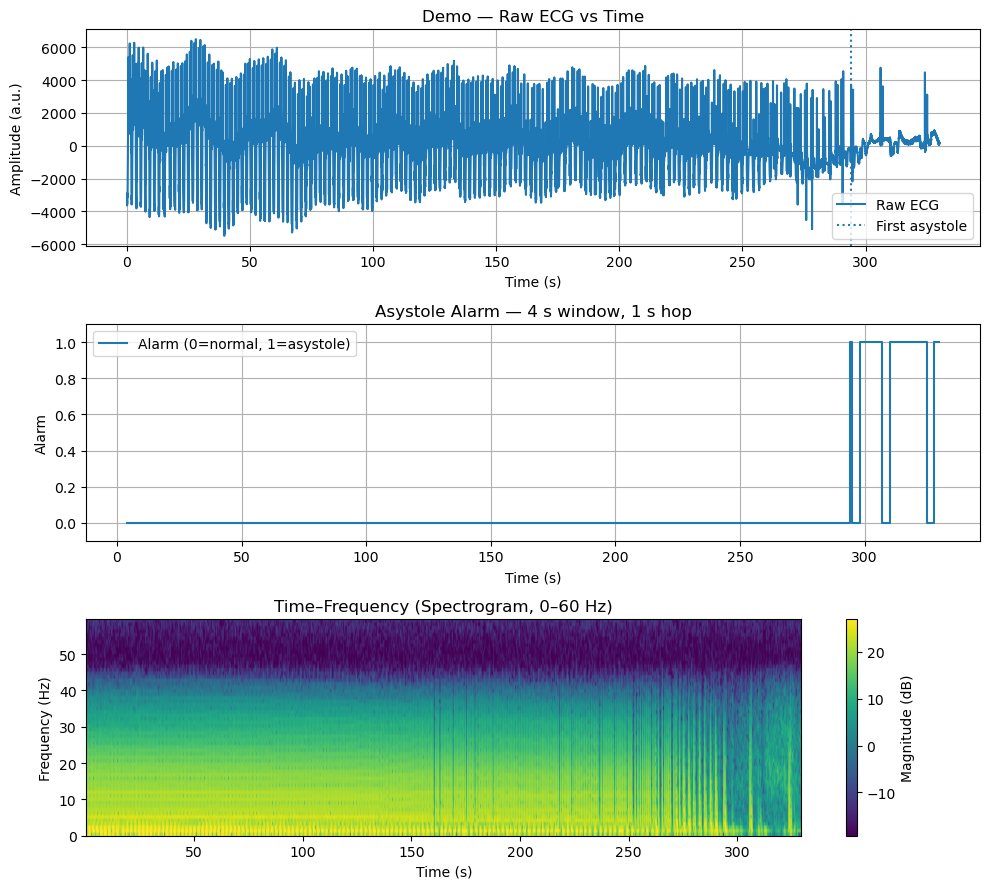

Saved spectrogram to spectrogram.png
Saved JSON summary to summary.json
Saved HTML report to report.html

=== DONE ===
First asystole time (s): 294.00


In [97]:
# ---- Single-file pipeline (run this) ----
# 1) Load ECG
try:
    p = ensure_exists(ecg_csv_path)
    x = read_csv_first_col(p)
    print(f"Loaded ECG from {p} with {x.size} samples.")
except FileNotFoundError as e:
    # Fallback: synthesize a toy ECG-like signal with an induced 4s pause
    print("ECG CSV not found. Generating a synthetic example...")
    dur = 20.0
    t = np.arange(int(dur*Fs))/Fs
    rr = 1.0   # 60 bpm
    r_times = np.arange(0.7, dur, rr)
    # create a 4s asystole between 12-16s
    r_times = r_times[(r_times < 12.0) | (r_times > 16.0)]
    x = np.zeros_like(t)
    width = int(0.02*Fs)
    for rt in r_times:
        idx = int(rt*Fs)
        i0, i1 = max(0, idx - width), min(x.size, idx + width + 1)
        g = np.exp(-0.5 * ((np.arange(i0, i1) - idx) / (0.008 * Fs)) ** 2)
        x[i0:i1] += 1.0 * g
    x += 0.05 * np.random.randn(x.size) + 0.1 * np.sin(2*np.pi*0.2*t)
    print(f"Generated synthetic ECG with {x.size} samples (Fs={Fs}).")


# 2) Detect
out = detect_asystole(x, fs=Fs, pause_thr_sec=pause_thr_sec)

# 3) Plot & save
fig = plot_overview(x, Fs, out, title_prefix="Demo — ")
fig.savefig(out_plot, dpi=150)
print(f"Saved plot to {out_plot}")
plt.show()

# 4) Spectrogram image
save_spectrogram_image(x, Fs, out_tfr)
print(f"Saved spectrogram to {out_tfr}")

# 5) Metrics & JSON/HTML export
def rr_intervals(rpeaks, fs):
    if rpeaks.size < 2: return np.array([])
    return np.diff(rpeaks)/fs
def heart_rate_series(rpeaks, fs):
    if rpeaks.size < 2: return np.array([]), np.array([])
    rr = rr_intervals(rpeaks, fs); t = rpeaks[1:]/fs; hr = 60.0/rr; return t, hr
def pause_segments(rpeaks, fs, thr_sec=3.0):
    segs=[]; 
    if rpeaks.size<2: return segs
    rr = rr_intervals(rpeaks, fs); t0 = rpeaks[:-1]/fs
    for ti,rri in zip(t0, rr):
        if rri>=thr_sec: segs.append((ti, ti+rri))
    return segs

rr = rr_intervals(out["rpeaks"], out["fs"])
_, hr = heart_rate_series(out["rpeaks"], out["fs"])
pauses = pause_segments(out["rpeaks"], out["fs"], thr_sec=pause_thr_sec)

summary = {
    "windows": int(out["alarm"].size),
    "first_asystole_time": out["first_asystole_time"],
    "mean_rr": float(np.mean(rr)) if rr.size else None,
    "mean_hr": float(np.mean(hr)) if hr.size else None,
    "pause_segments": pauses,
}
import json
Path(out_json).write_text(json.dumps(summary, indent=2), encoding="utf-8")
print(f"Saved JSON summary to {out_json}")

if out_html:
    write_html_report(out_html, Path(ecg_csv_path).name, summary,
                      plot_png=out_plot, tfr_png=out_tfr)
    print(f"Saved HTML report to {out_html}")


print("\n=== DONE ===")
print(f"First asystole time (s): {out['first_asystole_time']:.2f}")

## (Optional) Batch processing helper
This cell shows how you *could* loop over a folder of CSVs; it's minimal and commented out by default.

In [ ]:
# from glob import glob
# data_dir = "data"     # folder containing CSV files
# outdir = Path("results"); outdir.mkdir(parents=True, exist_ok=True)
# for csv in sorted(glob(f"{data_dir}/*.csv")):
#     x = read_csv_first_col(csv)
#     out = detect_asystole(x, fs=Fs, pause_thr_sec=pause_thr_sec)
#     fig = plot_overview(x, Fs, out, title_prefix=Path(csv).name + " — ")
#     fig.savefig(outdir / (Path(csv).stem + "_overview.png"), dpi=150); plt.close(fig)
# print("Batch done.")